In [ ]:
# %pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# %pip install pandas==1.3.3

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WkbQQuFL5dCaPGQz_YRu5Ne6-OEgj8Qs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WkbQQuFL5dCaPGQz_YRu5Ne6-OEgj8Qs" -O simple_image_classification.zip && rm -rf /tmp/cookies.txt

Unknown instance spec: wget

In [ ]:
!unzip -q -n simple_image_classification.zip

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torchvision

print(torch.__version__, torchvision.__version__, pd.__version__)

1.9.0+cu111 0.10.0+cu111 1.3.3


In [ ]:
import random
def set_seeds(val=23):
    torch.manual_seed(val)
    np.random.seed(val)
    random.seed(val)

set_seeds()

In [ ]:
FOLDER = 'simple_image_classification/'
from PIL import Image
import os
import glob

train_images = []
test_images = []

for file in sorted(glob.glob(FOLDER+'trainval/*')):
    train_images.append(np.array(Image.open(file)))

for file in sorted(glob.glob(FOLDER+'test/*')):
    test_images.append(np.array(Image.open(file)))

train_images = np.array(train_images)
test_images = np.array(test_images)

In [ ]:
train_images.shape

(100000, 40, 40, 3)

In [ ]:
labels = pd.read_csv(FOLDER+'labels_trainval.csv', usecols=[1])
labels = np.array(labels).reshape(-1)
labels.shape

(100000,)

In [ ]:
print(len(labels), len(train_images), len(test_images))

print(len(np.unique(labels)))

100000 100000 10000
200


In [ ]:
print(np.max(labels))

199


In [ ]:
X_all = train_images.astype(np.uint8)
X_test = test_images.astype(np.uint8)

In [ ]:
X_all = np.transpose(X_all, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

In [ ]:
indices = np.random.permutation(X_all.shape[0])
train_size = int(len(indices) * 0.9)
train_ids = indices[:train_size]
val_ids = indices[train_size:]

X_train = X_all[train_ids]
y_train = labels[train_ids]
X_val = X_all[val_ids]
y_val = labels[val_ids]

In [ ]:
X_train.dtype

dtype('uint8')

In [ ]:
#!g1.1

from torchvision import models, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, (0.5, 1.0), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_transforms['test'] = data_transforms['val']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (16,8)

def plot_history(train_history, val_history, title='loss'):
    plt.xlabel('train steps')
    #plt.ylbabel('loss')
    plt.title(title)
    plt.plot(train_history, label='train')
    plt.plot(np.arange(1, len(val_history) + 1) * len(train_history) / len(val_history) - 1, val_history, '+', mew=3, ms=15, label='val')
    plt.grid()
    plt.show()

In [ ]:
from tqdm.auto import tqdm

def iterate_minibatches(inputs, targets, batchsize, mode, todel, shuffle=True):
    assert len(inputs) == len(targets)
    siz = len(inputs)
    if todel != 1:
        inputs = inputs[:siz // todel]
        targets = targets[:siz // todel]
    if shuffle:
        indices = np.random.permutation(len(inputs))
    
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = np.array(range(start_idx, start_idx + batchsize))

        inp = inputs[excerpt]
        targ = targets[excerpt]
        yield data_transforms[mode](torch.from_numpy(inp)), torch.from_numpy(targ)



In [ ]:
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, nn.BatchNorm2d):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, nn.BatchNorm2d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [ ]:
import time
import torch.nn as nn
import copy

def train(num_epochs, model, optimizer, scheduler, criterion, use_gpu, todel, batchsize, onlytest=False, use_sam=False):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_model_epoch = -1

    for epoch in range(num_epochs):
        
        print('----------------------------')
        print('epoch', epoch, 'out of', num_epochs)
    
        train_loss_log = []
        train_acc_log = []
        val_loss_log = []
        val_acc_log = []
        
        lsttt = ['train', 'val']
        if onlytest:
            lsttt = lsttt[1:]
        
        for phase in lsttt:
            cur_time = time.time()
            
            if phase == 'train':
                model.train()
                iterator = iterate_minibatches(X_train, y_train, batchsize, 'train', todel, True)
            else:
                model.eval()
                iterator = iterate_minibatches(X_val, y_val, batchsize, 'val', todel, False)
            
            running_loss = 0.0
            running_corrects = 0
            
            total = 0
            
            cnter = 0
            
            if phase == 'train':
                optimizer.zero_grad()
            
            for inputs, labels in iterator:

                total += inputs.size()[0]
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                
                output = model(inputs)
                
                _, preds = torch.max(output, 1)

                loss = criterion(output, labels)
                        
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()

                if phase == 'train':
                    if not use_sam:
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    else:
                        # first forward-backward step
                        loss.backward()
                        optimizer.first_step(zero_grad=True)

                        # second forward-backward step
                        disable_running_stats(model)
                        criterion(model(inputs), labels).backward()
                        optimizer.second_step(zero_grad=True)
                        enable_running_stats(model)

                if phase == 'train':
                    train_loss_log.append(running_loss / total)
                    train_acc_log.append(running_corrects / total)
                else:
                    cnter += 1
                    if cnter == 10:
                        cnter = 0
                        val_loss_log.append(running_loss / total)
                        val_acc_log.append(running_corrects / total)
            
            if phase == 'val' and running_corrects / total > best_acc:
                best_acc = running_corrects / total
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_epoch = epoch
                print('made improvement', best_acc)
            
            if phase == 'val':
                if scheduler is not None:
                    scheduler.step(running_loss / total)
            
            print('phase is', phase)
            print('loss is', running_loss / total)
            print('accuracy is', running_corrects / total)
            tt = time.time() - cur_time
            print('this phase took {:.0f}m {:.0f}s'.format(tt // 60, tt % 60))
            
            if phase == 'val':
                tt = time.time() - start_time
                print('total elapsed time {:.0f}m {:.0f}s'.format(tt // 60, tt % 60))
                plot_history(train_loss_log, val_loss_log, 'loss')
                plot_history(train_acc_log, val_acc_log, 'accuracy')
        
    model.load_state_dict(best_model_wts)
    
    print('')
    print('best acc is', best_acc)
    print('got such acc at epoch', best_model_epoch)
    return model


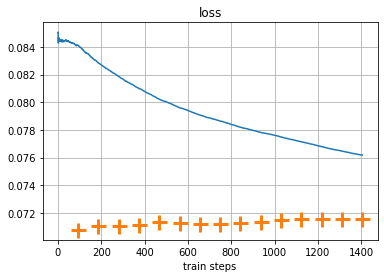

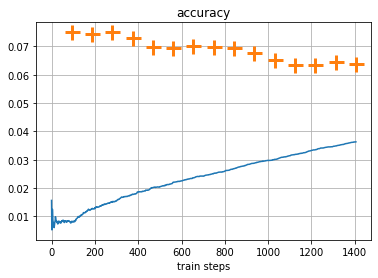

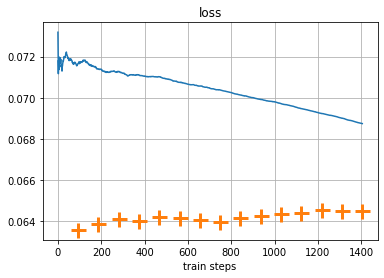

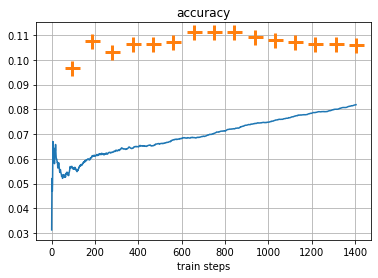

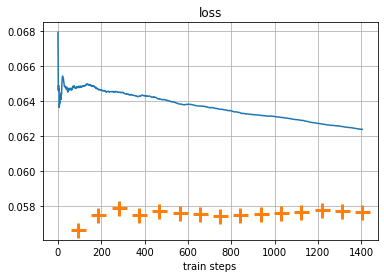

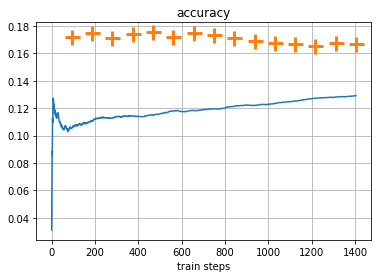

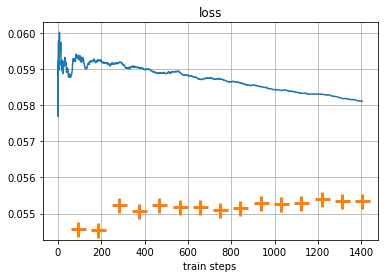

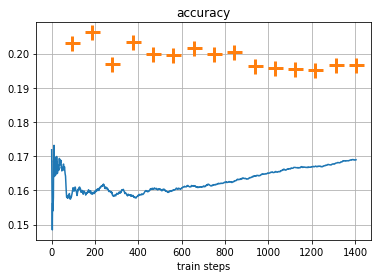

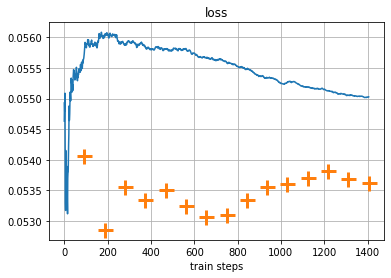

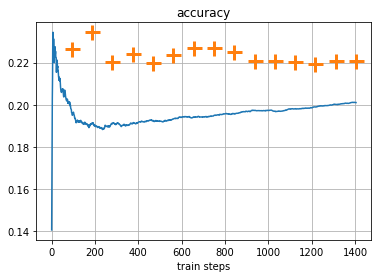

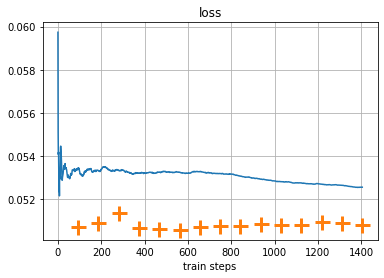

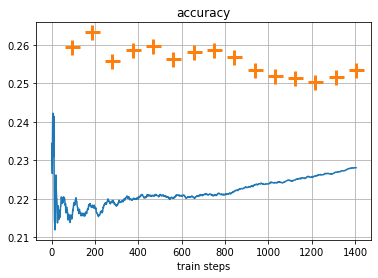

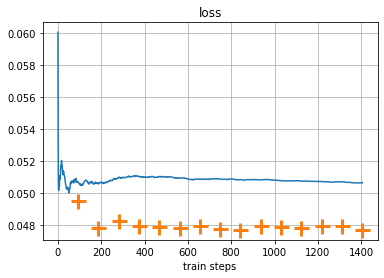

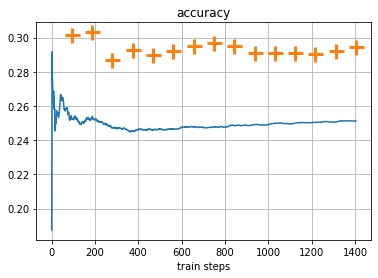

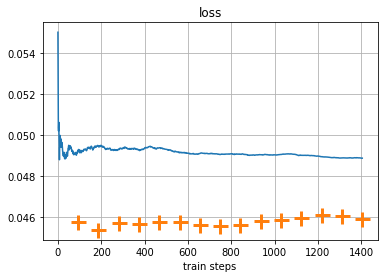

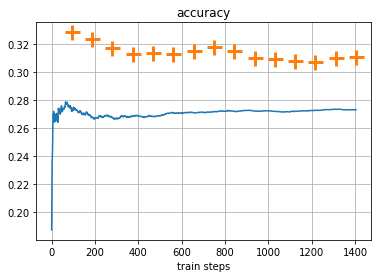

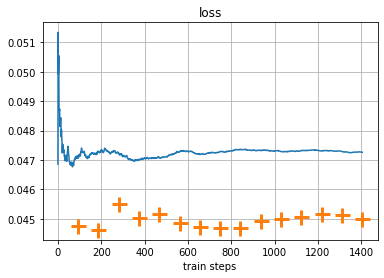

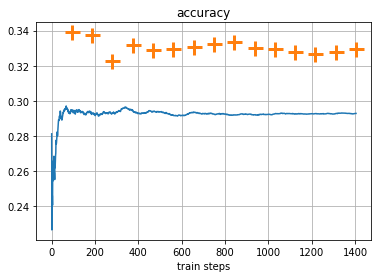

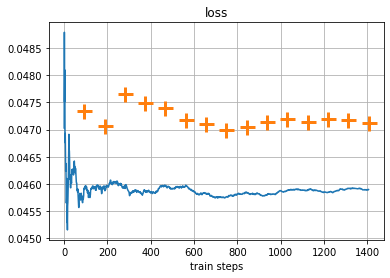

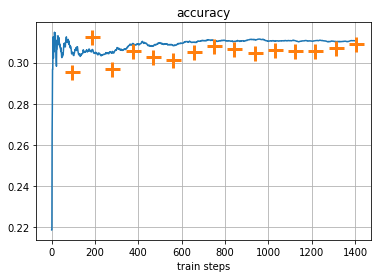

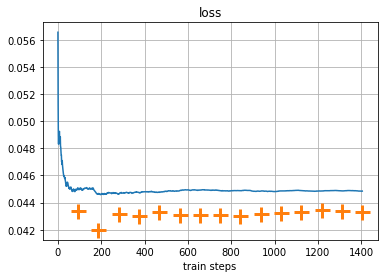

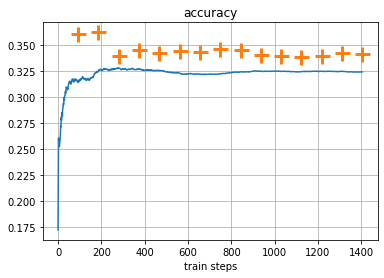

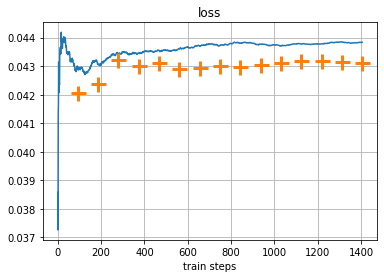

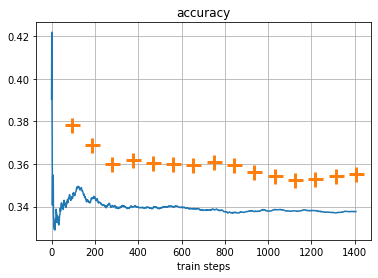

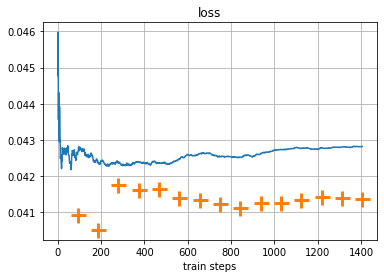

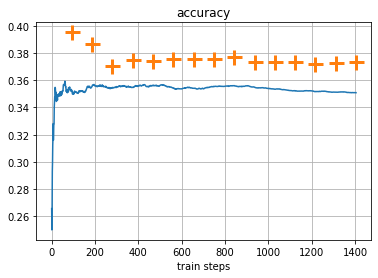

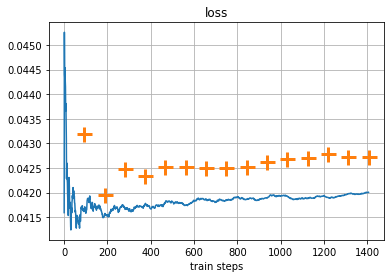

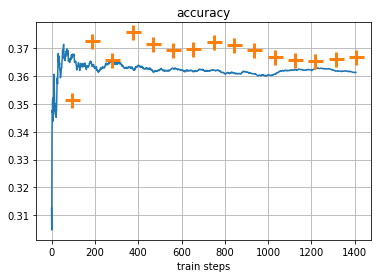

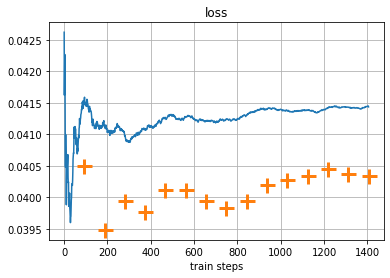

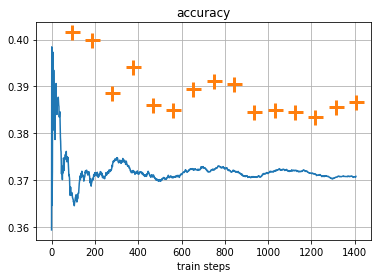

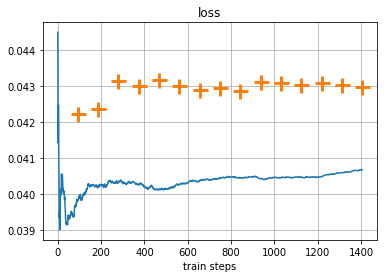

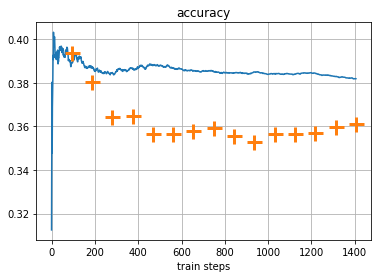

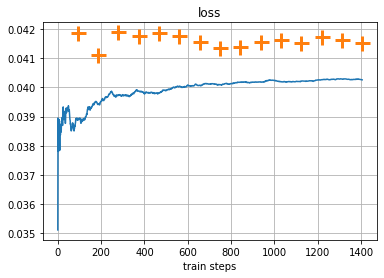

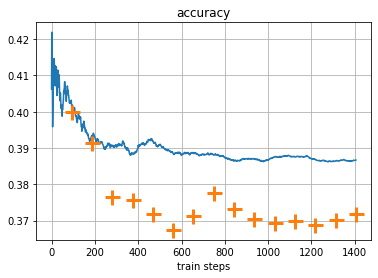

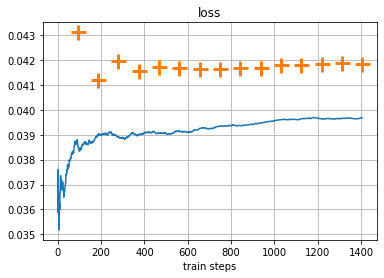

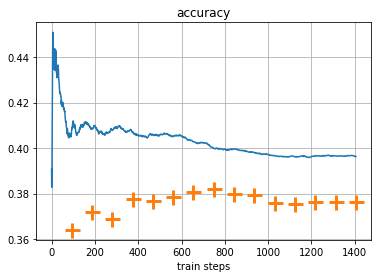

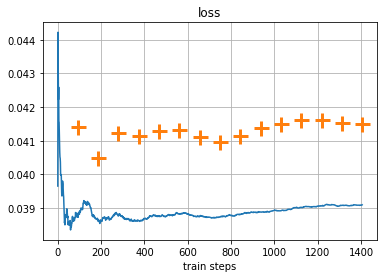

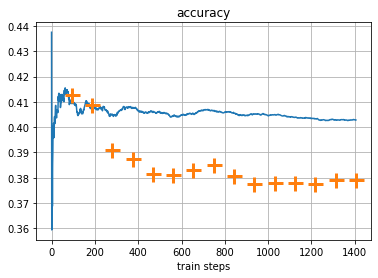

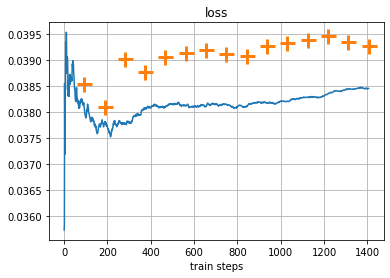

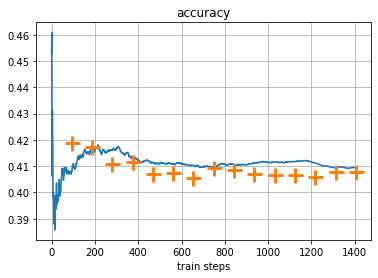

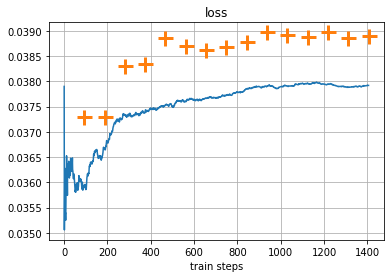

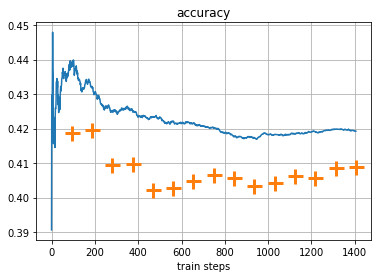

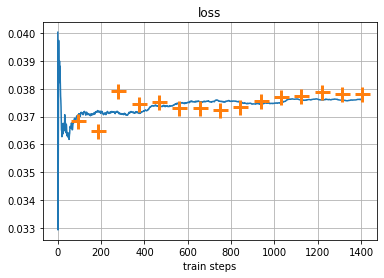

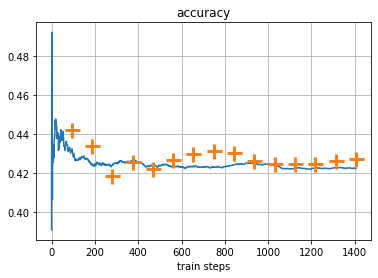

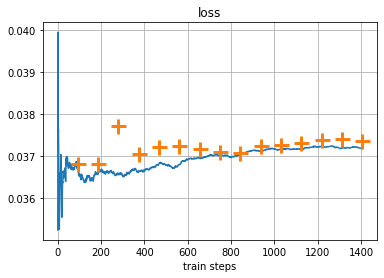

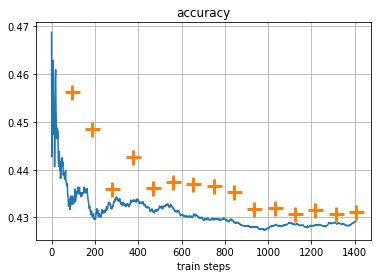

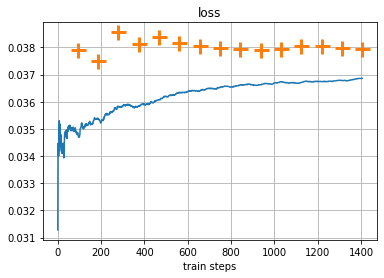

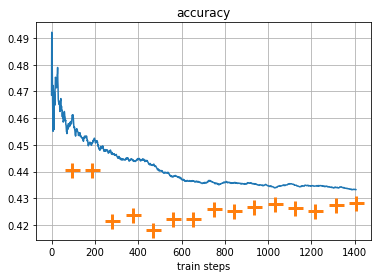

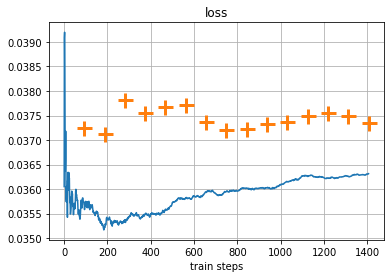

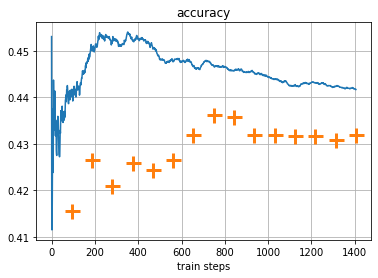

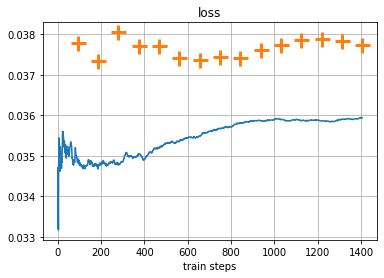

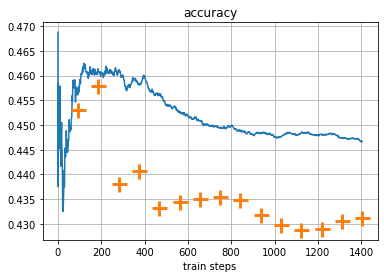

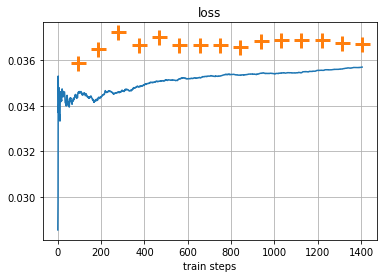

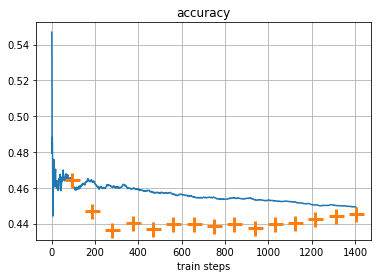

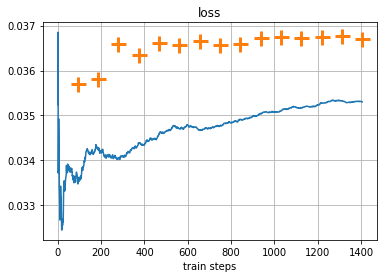

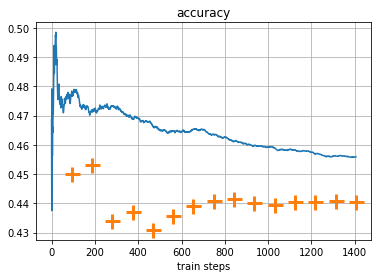

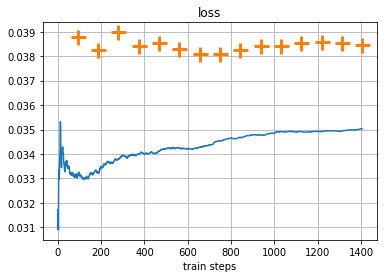

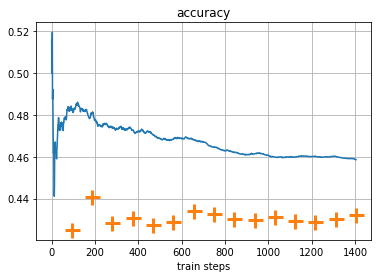

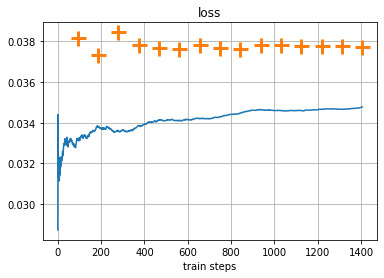

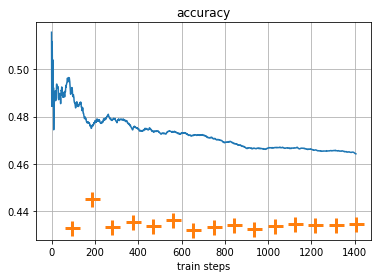

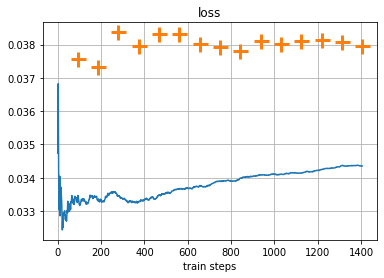

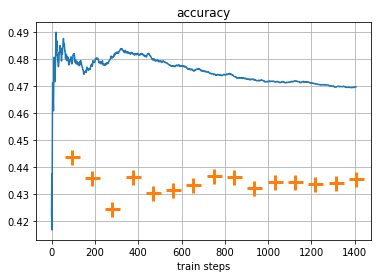

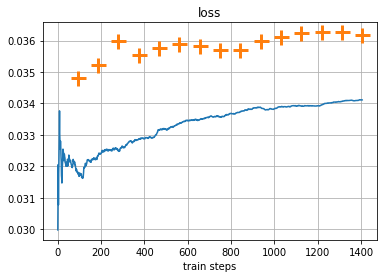

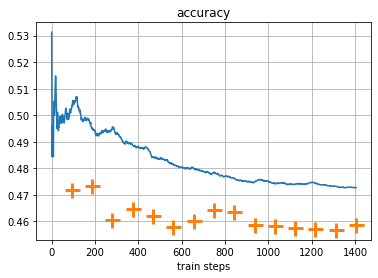

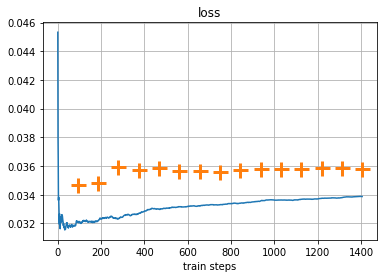

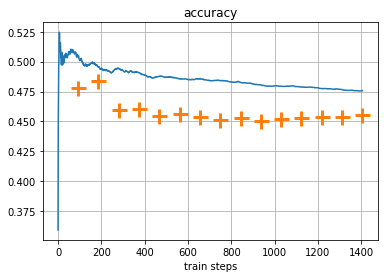

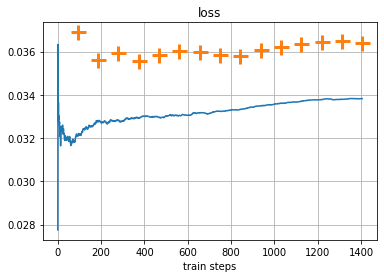

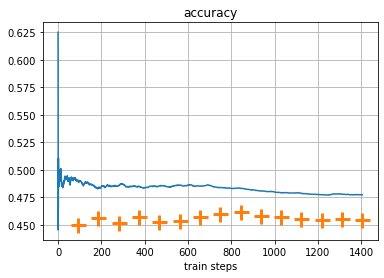

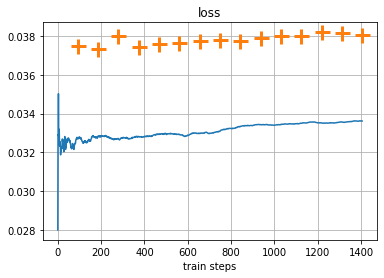

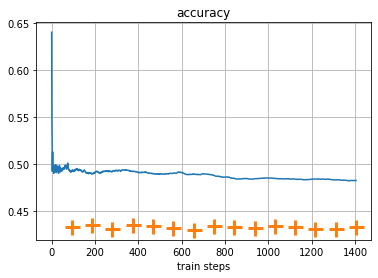

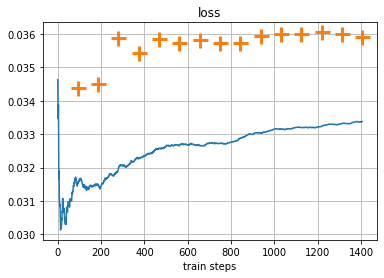

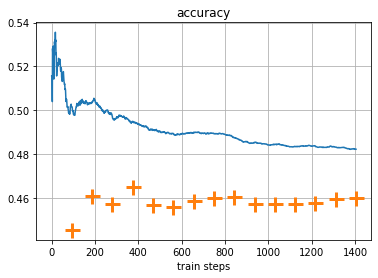

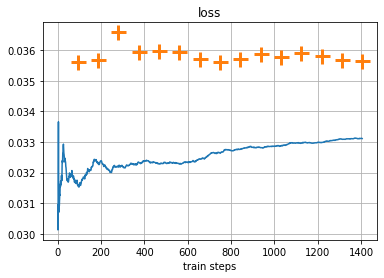

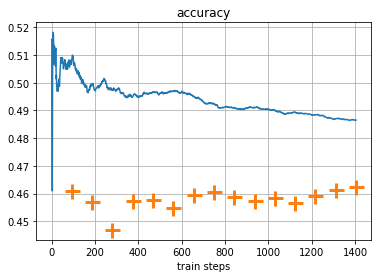

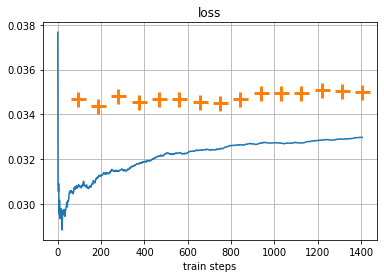

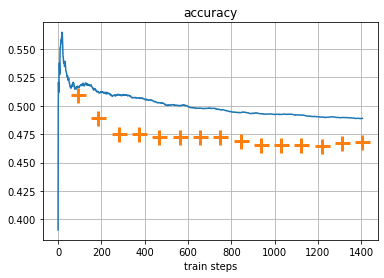

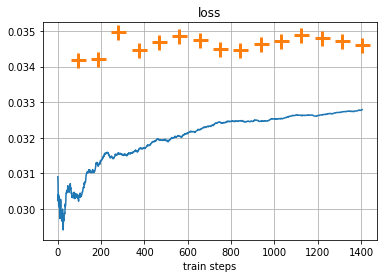

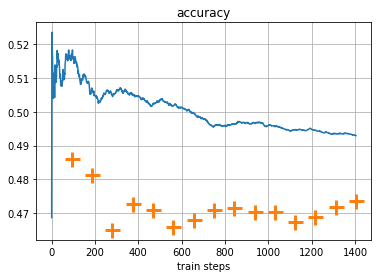

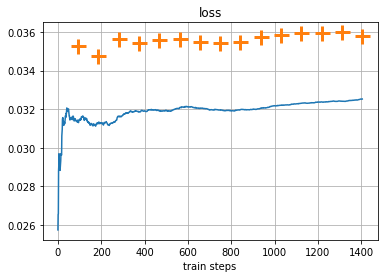

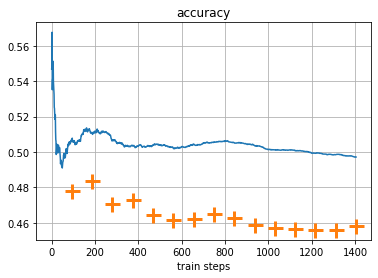

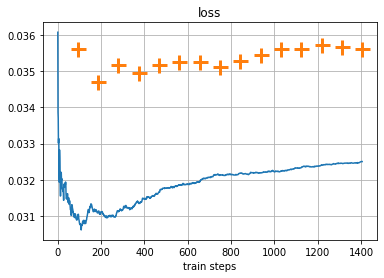

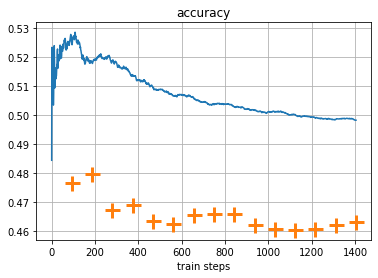

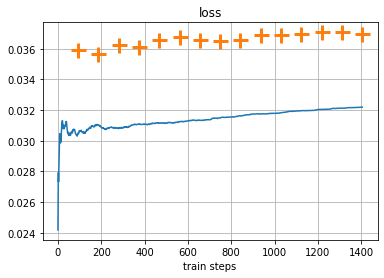

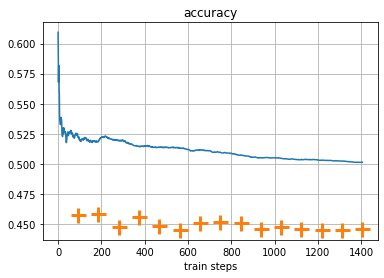

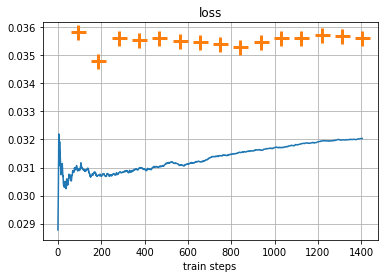

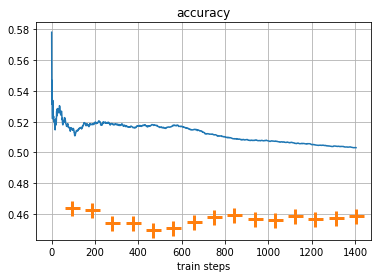

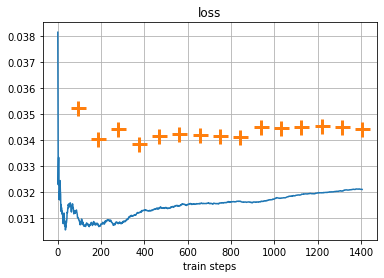

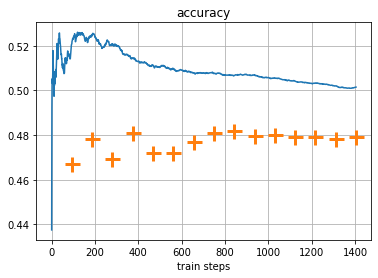

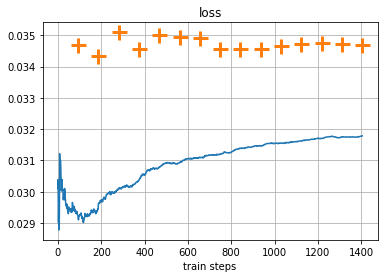

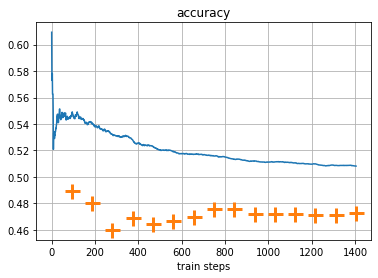

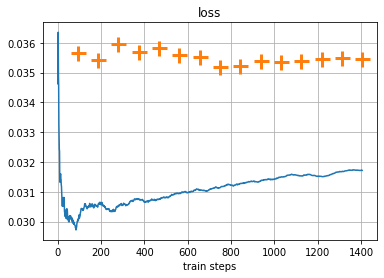

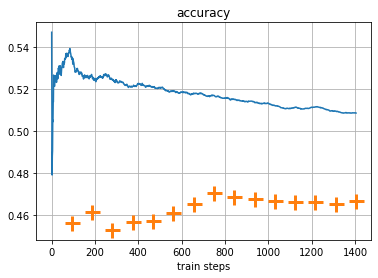

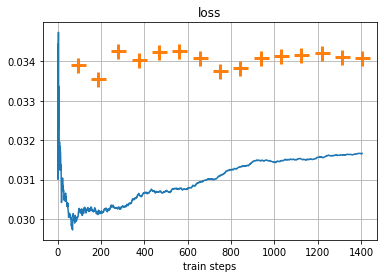

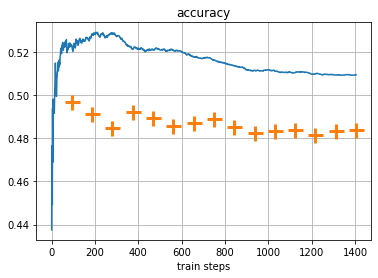

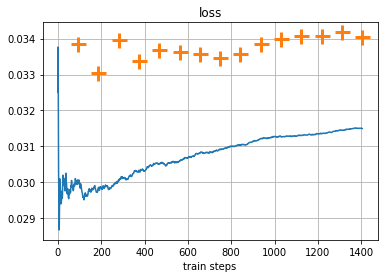

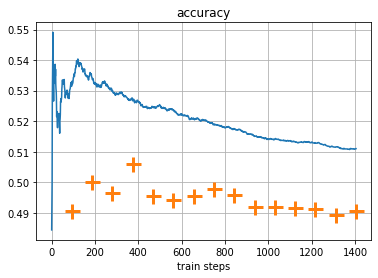

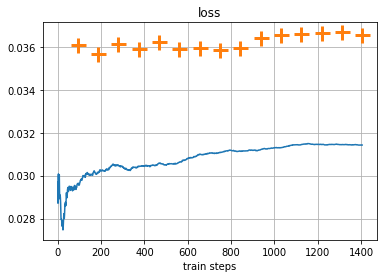

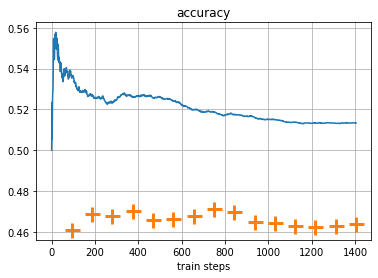

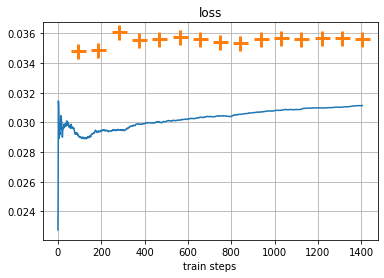

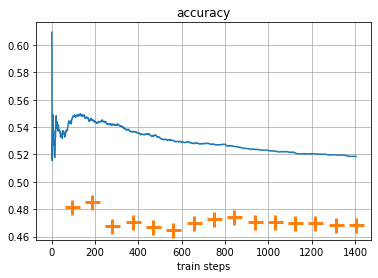

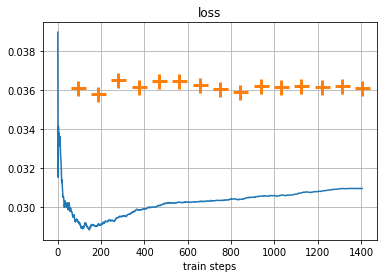

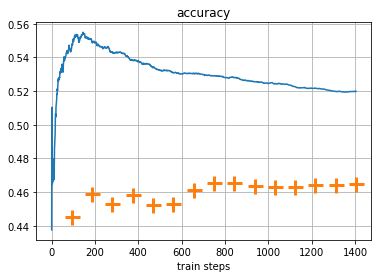

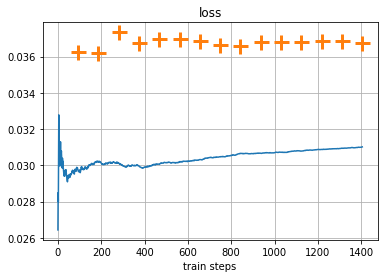

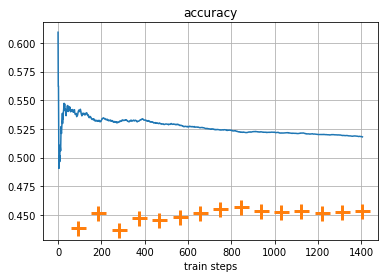

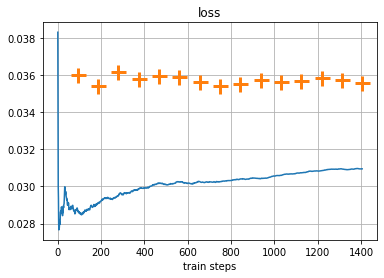

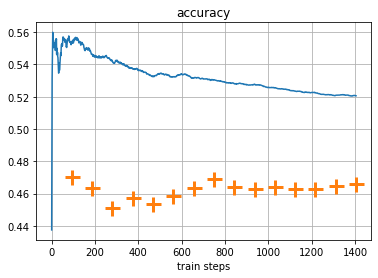

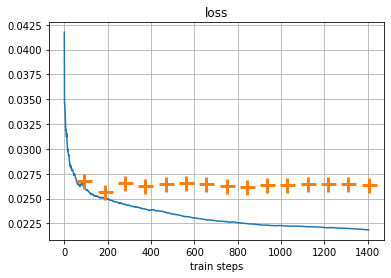

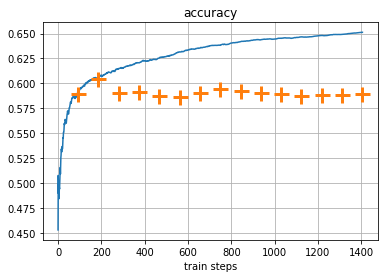

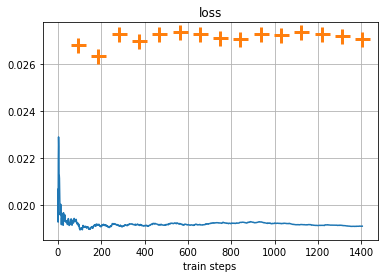

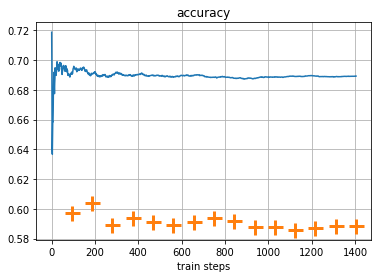

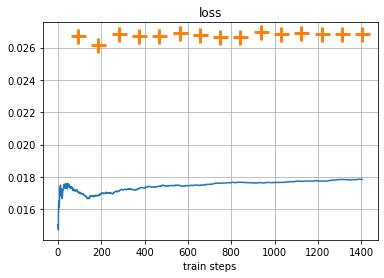

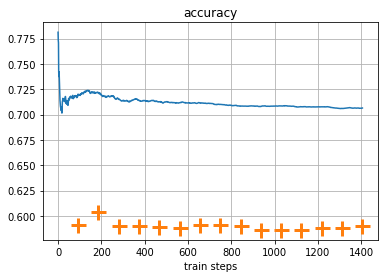

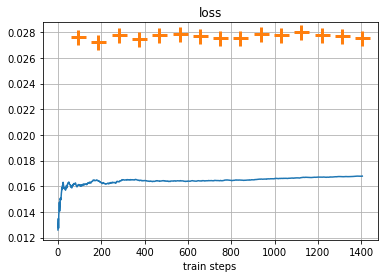

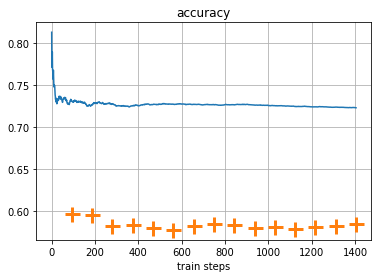

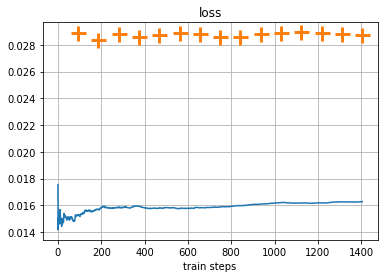

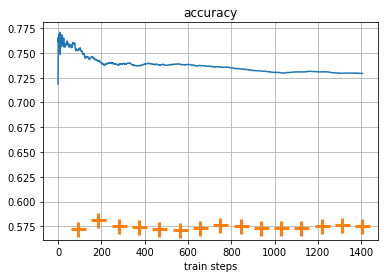

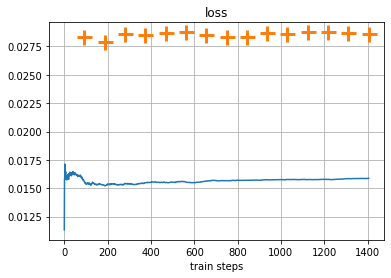

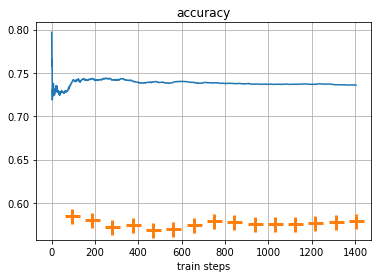

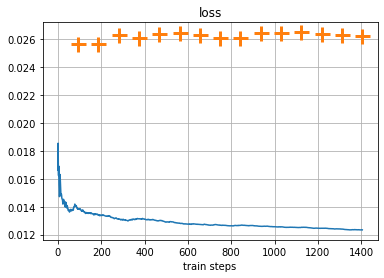

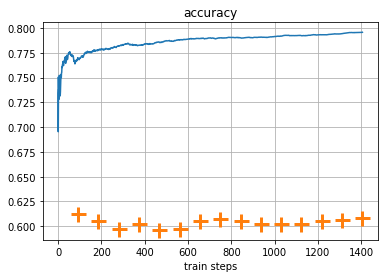

----------------------------
epoch 0 out of 60

phase is train
loss is 0.07617959909533199
accuracy is 0.036306454480796585
this phase took 4m 59s

phase is val
loss is 0.07153980820797957
accuracy is 0.06400240384615384
this phase took 0m 17s
total elapsed time 5m 16s
----------------------------
epoch 1 out of 60

phase is train
loss is 0.06874633689608377
accuracy is 0.08187011024182077
this phase took 4m 59s


phase is val
loss is 0.06447402060700533
accuracy is 0.1063701923076923
this phase took 0m 17s
total elapsed time 10m 32s
----------------------------
epoch 2 out of 60

phase is train
loss is 0.06239856030807895
accuracy is 0.12911184210526316
this phase took 4m 17s

phase is val
loss is 0.05769506321312525
accuracy is 0.1677684294871795
this phase took 0m 14s
total elapsed time 15m 3s
----------------------------
epoch 3 out of 60

phase is train
loss is 0.058107453826311474
accuracy is 0.16895225817923187
this phase took 4m 22s

phase is val
loss is 0.055365569197023526
ac

In [ ]:
#!g1.1
use_gpu = torch.cuda.is_available()

if use_gpu:
    torch.cuda.manual_seed_all(223)

import torch.nn.functional as F
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

model = models.resnet34(pretrained=False)

model.fc = nn.Sequential(
    nn.Linear(512, 300),
    nn.Dropout(0.5),
    nn.Linear(300, 200)
)

for params in model.parameters():
    params.requires_grad = True

params_to_train = list(model.parameters())

if use_gpu:
    model = model.cuda()

#optimizer_ft = SAM(params_to_train, optim.SGD, 0.05, False, lr=0.01, momentum=0.9, weight_decay=0.001)
optimizer_ft = optim.SGD(params_to_train, lr=0.01, momentum=0.9, weight_decay=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.2, patience=4, threshold_mode='rel', 
                                           cooldown=0, verbose=True, eps=1e-6, threshold=1e-3)

model = train(60, model, optimizer_ft, scheduler, nn.CrossEntropyLoss(), use_gpu, 1, 64, False, False)

In [ ]:
#!g1.1
model_60_dict = copy.deepcopy(model.state_dict())

----------------------------
epoch 0 out of 10


/kernel/lib/python3.7/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)
/kernel/lib/python3.7/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


----------------------------
epoch 0 out of 10


/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



phase is train
loss is 0.01116868160343113
accuracy is 0.8141558499288762
this phase took 5m 31s



phase is val
loss is 0.02656409284696938
accuracy is 0.6059695512820513
this phase took 0m 22s
total elapsed time 5m 52s


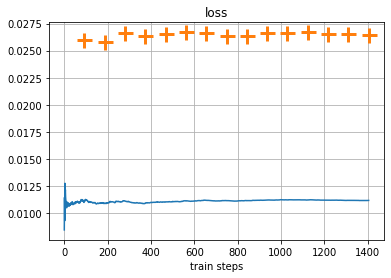

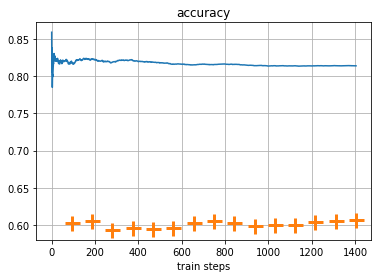

----------------------------
epoch 1 out of 10



phase is train
loss is 0.010522822809046609
accuracy is 0.8243687766714083
this phase took 5m 6s


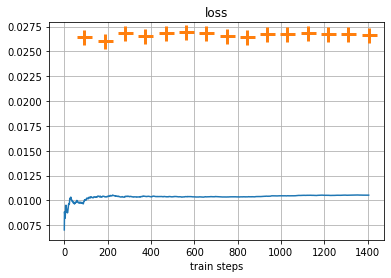

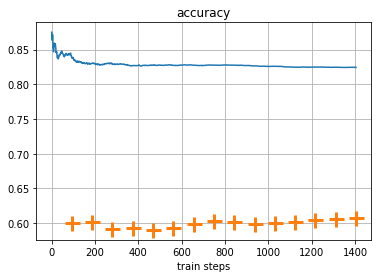


phase is val
loss is 0.026754796313933838
accuracy is 0.6070713141025641
this phase took 0m 18s
total elapsed time 11m 18s
----------------------------
epoch 2 out of 10



phase is train
loss is 0.009887563517273459
accuracy is 0.8357596906116643
this phase took 4m 58s



phase is val
loss is 0.02721825175178357
accuracy is 0.6033653846153846
this phase took 0m 17s
total elapsed time 16m 33s


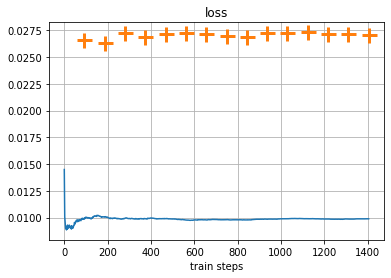

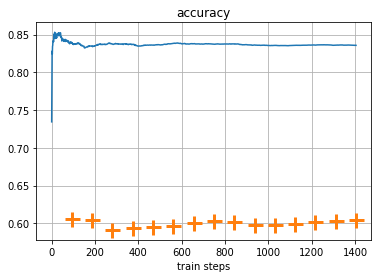

----------------------------
epoch 3 out of 10



phase is train
loss is 0.009759881161915066
accuracy is 0.8355707681365576
this phase took 4m 57s


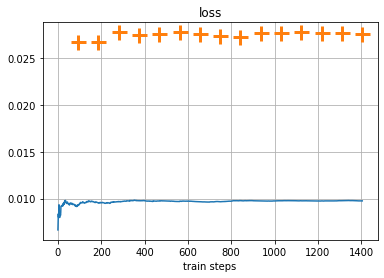

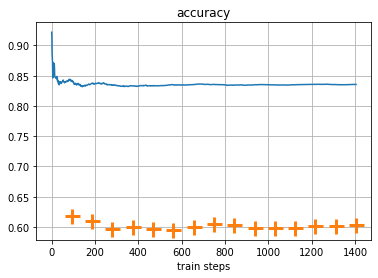


phase is val
loss is 0.027682319820786897
accuracy is 0.6022636217948718
this phase took 0m 17s
total elapsed time 21m 48s
----------------------------
epoch 4 out of 10



phase is train
loss is 0.00929663050853532
accuracy is 0.8433388157894737
this phase took 4m 59s


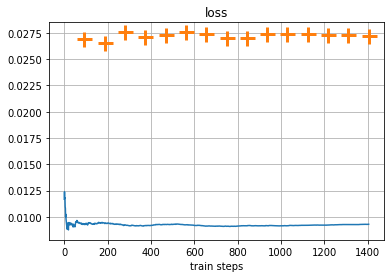

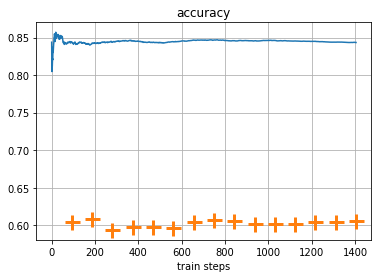


Epoch    65: reducing learning rate of group 0 to 8.0000e-05.
phase is val
loss is 0.027354386133643296
accuracy is 0.6051682692307693
this phase took 0m 18s
total elapsed time 27m 5s
----------------------------
epoch 5 out of 10



phase is train
loss is 0.008420148415286969
accuracy is 0.8607085704125178
this phase took 5m 5s



phase is val
loss is 0.026999119490098495
accuracy is 0.6080729166666666
this phase took 0m 17s
total elapsed time 32m 27s


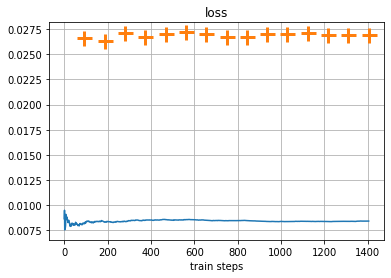

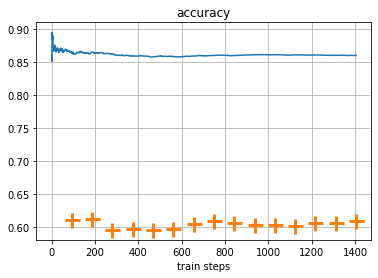

----------------------------
epoch 6 out of 10



phase is train
loss is 0.00842224752744408
accuracy is 0.8600084459459459
this phase took 5m 1s


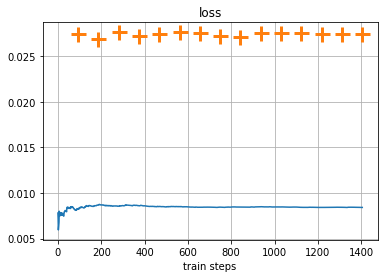

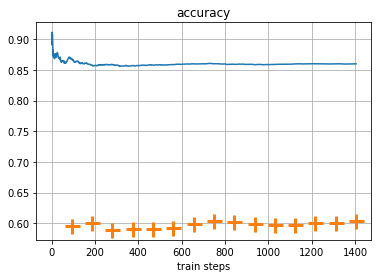


phase is val
loss is 0.027566139007178254
accuracy is 0.6025641025641025
this phase took 0m 17s
total elapsed time 37m 45s
----------------------------
epoch 7 out of 10



phase is train
loss is 0.008241912161111354
accuracy is 0.8632201280227596
this phase took 5m 5s


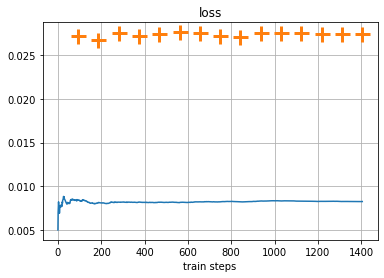

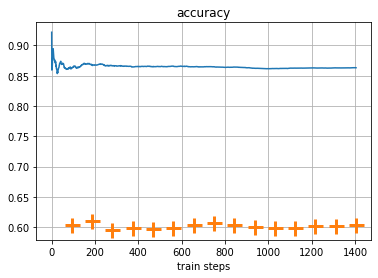


phase is val
loss is 0.02754477232408065
accuracy is 0.6033653846153846
this phase took 0m 17s
total elapsed time 43m 8s
----------------------------
epoch 8 out of 10



phase is train
loss is 0.008047960757557435
accuracy is 0.8663317923186344
this phase took 4m 59s


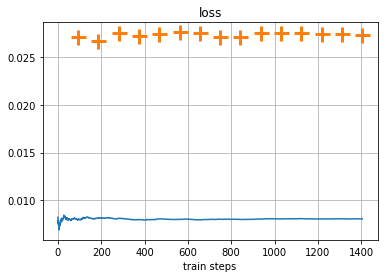

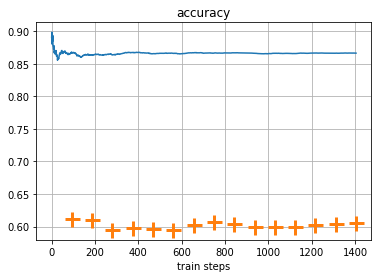


phase is val
loss is 0.027501862591657884
accuracy is 0.6040665064102564
this phase took 0m 17s
total elapsed time 48m 25s
----------------------------
epoch 9 out of 10



phase is train
loss is 0.007883843317678248
accuracy is 0.8695101351351351
this phase took 5m 6s


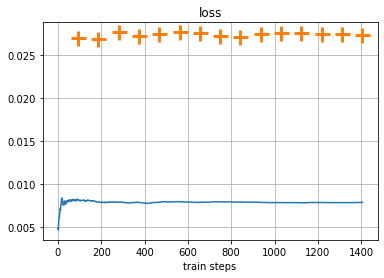

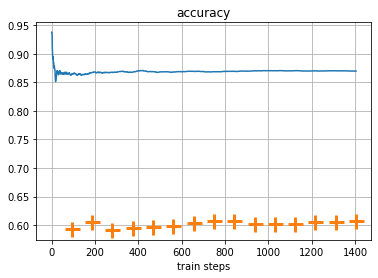


Epoch    70: reducing learning rate of group 0 to 1.6000e-05.
phase is val
loss is 0.0274270588102249
accuracy is 0.6063701923076923
this phase took 0m 14s
total elapsed time 53m 45s

best acc is 0.6080729166666666
got such acc at epoch 5


In [ ]:
#!g1.1
model = train(10, model, optimizer_ft, scheduler, nn.CrossEntropyLoss(), use_gpu, 1, 64, False, False)

In [ ]:
#!g1.1

def save_answer(model, use_gpu, batchsize):
    res = []
    model.eval()
    inputs = torch.from_numpy(X_test)
    inputs = data_transforms['val'](inputs)
    if use_gpu:
        inputs = inputs.cuda()
    
    num = 0
    for start_idx in range(0, len(inputs), batchsize):
        output = model(inputs[start_idx: start_idx + batchsize])
        _, preds = torch.max(output, 1)

        for each in preds:
            res.append(np.array(['test_' + str(num).zfill(5) + '.jpg', str(each.item()).zfill(4)]))
            num += 1
    
    df = pd.DataFrame(np.array(res), columns=['Id', 'Category'])
    df.to_csv('labels_test.csv', index=False)   
    

save_answer(model, use_gpu, 32)